In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler

In [2]:
torch.manual_seed(1)

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [6]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt={}
    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #print(epoch,i)
            
            #Weight Collection
            if epoch % 3 == 0:
                for name, parameter in model.named_parameters():
                    #print(name)
                    if'weight' in name:
                        modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                        #print(modelParamWgt)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
               
                        
    trainAvgLoss = lossSum/train_batch_size
    print("Train Avg loss:",trainAvgLoss)
                        
    return train_epoch,train_losses,train_acc,trainAvgLoss, modelParamWgt

In [7]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [19]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    scale = StandardScaler()

    sData = scale.fit_transform(paramDF)

    pcaVal = pcaOperation.fit_transform(sData)

    itrData = np.full((pcaVal.shape[0],1),itr)

    #pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [38]:
#Main Implementation

modelParamArr = []
pcaDf = pd.DataFrame(columns=['x','y','Itr No.'])


for itr in range(2):
    print('Iteration No:', itr)
    j = copy.deepcopy(itr) 
    j = Model()
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(j.parameters(), lr=0.0015, weight_decay = 1e-4)

    max_epochs = 15
    train_batch_size = int(6000)
    test_batch_size = int(100)
    status_interval = 10

    train_epoch,train_losses,train_acc,trainAvgLoss, modelParamWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)

    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    #modelParamArr.append(modelParamWgt.values())

    paramDF = pd.DataFrame.from_dict(data=modelParamWgt,orient='index')

    
    #PCA Dim Reduction.
    pcaOperation =  PCA(n_components=2)

    scale = StandardScaler()

    sData = scale.fit_transform(paramDF)

    pcaVal = pcaOperation.fit_transform(sData)

    itrData = np.full((pcaVal.shape[0],1),itr)

    #pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

    tempDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    pcaDf = pcaDf.append(tempDf, ignore_index=True)

    #pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    #resultDf = pcaOps(paramDF,itr)



Iteration No: 0
strated
Train Avg loss: tensor(0.0002, grad_fn=<DivBackward0>)


TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

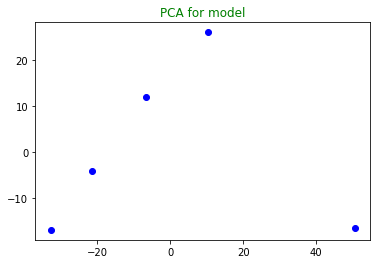

In [ ]:
#Visualize the Optimization Process

plt.scatter(pcaDf['x'],pcaDf['y'],color="Blue")
plt.title("PCA for model",color="g")

plt.show()

In [34]:
tempData

array([[ 52.34460831, -14.32252502,   0.        ],
       [  8.18269444,  23.91380692,   0.        ],
       [ -8.30943966,  12.75551414,   0.        ],
       [-20.90570831,  -3.81560445,   0.        ],
       [-31.31209564, -18.53119278,   0.        ]])

In [ ]:
paramDF

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
3,0.117564,0.014307,-0.075532,0.076026,-0.067839,-0.052811,-0.110147,-0.034520,0.046511,-0.035932,...,-0.006191,-0.124151,0.048117,0.122245,-0.123885,0.026735,-0.068712,0.068010,-0.118104,0.053652
6,0.122224,0.013080,-0.063526,0.076529,-0.079562,-0.050047,-0.107680,-0.014998,0.040480,-0.009068,...,-0.004734,-0.110660,0.067423,0.120205,-0.161034,0.038831,-0.053685,0.065366,-0.132502,0.050665
9,0.126328,0.012067,-0.056330,0.077770,-0.081589,-0.047198,-0.104539,-0.019767,0.039037,-0.012085,...,-0.010970,-0.111702,0.079076,0.118276,-0.194864,0.033695,-0.038436,0.064421,-0.131541,0.047479
12,0.127561,0.010979,-0.050411,0.077413,-0.080743,-0.044032,-0.107599,-0.019042,0.037173,-0.018347,...,-0.016896,-0.115866,0.087569,0.116077,-0.223273,0.025398,-0.025667,0.065067,-0.129104,0.043955
15,0.128591,0.009852,-0.045130,0.077372,-0.078854,-0.040668,-0.110636,-0.017943,0.034705,-0.020888,...,-0.020674,-0.120453,0.092560,0.114321,-0.247307,0.016488,-0.016050,0.066087,-0.126885,0.040239
